# Imports

In [1]:
import argparse
import os
import sys
sys.path.append("../")
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"

In [2]:
import glob
import albumentations
import pandas as pd
import zeus
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from sklearn import metrics, model_selection, preprocessing
from zeus.callbacks import EarlyStopping, TensorBoardLogger, GradientClipping, PlotLoss
from zeus.metrics import LabelSmoothingCrossEntropy
from zeus.datasets import ImageDataset
from albumentations.pytorch import ToTensorV2
from torch.nn import functional as F

In [3]:
from zeus.utils.model_helpers import *

# Defining

## Params

In [4]:
INPUT_PATH = "/media/hdd/Datasets/blindness/"
MODEL_PATH = "./models/"
MODEL_NAME = os.path.basename("blindness.pt")
TRAIN_BATCH_SIZE = 140
VALID_BATCH_SIZE = 140
IMAGE_SIZE = 192

In [5]:
class Model(zeus.Model):
    def __init__(self, num_classes):
        super().__init__()

        self.effnet = EfficientNet.from_pretrained("efficientnet-b0")
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(1280, num_classes)

    def monitor_metrics(self, outputs, targets):
        outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, outputs)
        return {"accuracy": accuracy}

    def fetch_optimizer(self):
        opt = torch.optim.AdamW(self.parameters(), lr=1e-4)
        return opt

    def forward(self, image, targets=None):
        batch_size, _, _, _ = image.shape

        x = self.effnet.extract_features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        outputs = self.out(self.dropout(x))

        if targets is not None:
            #  loss = nn.CrossEntropyLoss()(outputs, targets)
            loss = LabelSmoothingCrossEntropy()(outputs, targets)
            metrics = self.monitor_metrics(outputs, targets)
            return outputs, loss, metrics
        return outputs, 0, {}

In [6]:
train_aug = albumentations.Compose(
    [
        albumentations.Resize(IMAGE_SIZE,IMAGE_SIZE),
        albumentations.Transpose(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.ShiftScaleRotate(p=0.5),
        albumentations.HueSaturationValue(
            hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
        ),
        albumentations.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
        ),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
    ],
    p=1.0,
)

valid_aug = albumentations.Compose(
    [
        albumentations.Resize(IMAGE_SIZE,IMAGE_SIZE),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
    ],
    p=1.0,
)

In [7]:
# train_image_paths = glob.glob(
#     os.path.join(
#         INPUT_PATH, f"jpeg-{IMAGE_SIZE}x{IMAGE_SIZE}", "train", "**", "*.jpeg"
#     ),
#     recursive=True,
# )

# valid_image_paths = glob.glob(
#     os.path.join(
#         INPUT_PATH, f"jpeg-{IMAGE_SIZE}x{IMAGE_SIZE}", "val", "**", "*.jpeg"
#     ),
#     recursive=True,
# )

In [8]:
# train_targets = [x.split("/")[-2] for x in train_image_paths]
# valid_targets = [x.split("/")[-2] for x in valid_image_paths]

## Data pre process

In [9]:
df = pd.read_csv(INPUT_PATH+"trainLabels.csv");df.head(3)

,image,level
0,10_left,0
1,10_right,0
2,13_left,0


In [10]:
df["image"] = INPUT_PATH+"trainImages/"+df["image"]+".jpg"; df.head(3)

,image,level
0,/media/hdd/Datasets/blindness/trainImages/10_l...,0
1,/media/hdd/Datasets/blindness/trainImages/10_r...,0
2,/media/hdd/Datasets/blindness/trainImages/13_l...,0


In [11]:
# SUBSET REMOVE LATER
df = df.head(5000)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_images ,valid_images =  train_test_split(df, test_size=.33)

In [14]:
train_image_paths, valid_image_paths = train_images["image"].values , valid_images["image"].values

In [15]:
train_targets, valid_targets = train_images["level"].values , valid_images["level"].values

## Training

In [16]:
lbl_enc = preprocessing.LabelEncoder()
train_targets = lbl_enc.fit_transform(train_targets)
valid_targets = lbl_enc.transform(valid_targets)

In [17]:
train_dataset = ImageDataset(
    image_paths=train_image_paths,
    targets=train_targets,
    augmentations=train_aug,
)

valid_dataset = ImageDataset(
    image_paths=valid_image_paths,
    targets=valid_targets,
    augmentations=valid_aug,
)

## Callbacks

In [18]:
model = Model(num_classes=len(lbl_enc.classes_))

es = EarlyStopping(
    monitor="valid_loss",
    model_path=os.path.join(MODEL_PATH, MODEL_NAME + ".bin"),
    patience=3,
    mode="min",
)

tb = TensorBoardLogger()
grc = GradientClipping(5)
pl = PlotLoss(2)

Loaded pretrained weights for efficientnet-b0


In [19]:
count_parameters(model, showtable=False)

Total Trainable Params: 5294953


5294953

100%|███████| 12/12 [00:05<00:00,  2.15it/s, accuracy=0.729, loss=1.02, stage=valid]


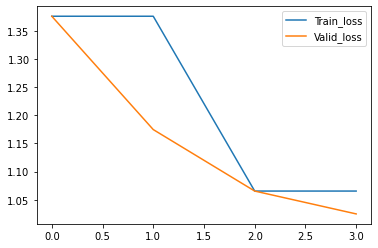

In [20]:
EPOCHS = 2

model.fit(
    train_dataset,
    valid_dataset=valid_dataset,
    train_bs=TRAIN_BATCH_SIZE,
    valid_bs=VALID_BATCH_SIZE,
    device="cuda",
    epochs=EPOCHS,
    callbacks=[grc, pl, tb],
#     callbacks=[es, tb],
    fp16=True,
)